# Neuronal Networks and Deep Learning

## Stacked Denoising Autoencoder

by 

[__Michael Granitzer__ (michael.granitzer@uni-passau.de)]( http://www.mendeley.com/profiles/michael-granitzer/)

with examples taken from the scikit-learn documentation under http://scikit-learn.org/stable/


__License__

This work is licensed under a [Creative Commons Attribution 3.0 Unported License](http://creativecommons.org/licenses/by/3.0/)

#Table of Contents
* [Neuronal Networks and Deep Learning](#Neuronal-Networks-and-Deep-Learning)
	* [Stacked Denoising Autoencoder](#Stacked-Denoising-Autoencoder)
* [3. Introduction](#3.-Introduction)
* [4. Theory](#4.-Theory)
* [5. Toy Example](#5.-Toy-Example)
	* [5.1 Data First: A Circle and a Sphere](#5.1-Data-First:-A-Circle-and-a-Sphere)
	* [5.2 The Autoencoder](#5.2-The-Autoencoder)
		* [5.2.1 Training and Testing on a circle](#5.2.1-Training-and-Testing-on-a-circle)
		* [5.2.2 Training a sphere](#5.2.2-Training-a-sphere)
		* [5.2.3 Bi-Spherical Data](#5.2.3-Bi-Spherical-Data)
	* [5.3 Training and testing elastic learning](#5.3-Training-and-testing-elastic-learning)
		* [5.3.1 Functional test of elastic learning](#5.3.1-Functional-test-of-elastic-learning)
		* [5.3.2 Training an Elastic Autoencoder on a Sphere](#5.3.2-Training-an-Elastic-Autoencoder-on-a-Sphere)
		* [5.3.3 Training an Elastic Autoencoder on a Bi-Sphere](#5.3.3-Training-an-Elastic-Autoencoder-on-a-Bi-Sphere)
	* [5.4 Truly Elastic training - no weight updates to previous units](#5.4-Truly-Elastic-training---no-weight-updates-to-previous-units)
		* [5.4.1 Embedding a sphere - looks like traditional AEs and Elastic1](#5.4.1-Embedding-a-sphere---looks-like-traditional-AEs-and-Elastic1)
		* [5.4.2 Embedding a Bi-Sphere - Elastic 2 choose directions of greatest variance (!?!)](#5.4.2-Embedding-a-Bi-Sphere---Elastic-2-choose-directions-of-greatest-variance-%28!?!%29)


# 3. Introduction

This notebook outlines Stacked Denoising Autoencoders through small examples using python.

# 4. Theory

TODO:

# 5. Toy Example

In this toy example we will take a simple 2D circle and 3D sphere and learn it using a stacked denoising autoencoder.

In [66]:
%pylab inline
import numpy as np
import math
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D
import mpld3
import matplotlib.pylab as pylab
import itertools
pylab.rcParams['figure.figsize']=(14,6)

Populating the interactive namespace from numpy and matplotlib


## 5.1 Data First: A Circle and a Sphere

In [99]:
def circle(r=[1.0, 1.0], num=1000, circle=False, seed=1357):
    d = np.zeros((2,num))
    state = np.random.RandomState(seed)
    for i in xrange(num):
        phi = 2*math.pi*state.rand() # x y angle
        d[0,i],d[1,i] = r[0]*math.cos(phi), r[1] * math.sin(phi)
    return d

def sphere(r=[1.0, 1.0, 1.0], num=1000, circle=False, seed=1357):
    d = np.zeros((3, num))
    state = np.random.RandomState(seed)
    for i in xrange(num):
        phi = 2*math.pi*state.rand() # x y angle
        theta = 2*math.pi*state.rand() # x y angle
        sin_theta = math.sin(theta)
        d[1,i],d[0,i],d[2,i] =r[1] * sin_theta * math.sin(phi) , r[0] * sin_theta* math.cos(phi), r[2]*math.cos(theta)
    return d

def scatter3D(data, fig=None, pos=111):
    if fig is None:
        fig = plt.figure()
    ax = fig.add_subplot(pos, projection='3d')
    ax.scatter(data[0], data[1], data[2])
    return fig

def line(k=[0.1, 0.1, 0.0], num=1000,  seed=1357):
    k = np.array(k)
    d = np.zeros((k.shape[0],num))
    state = np.random.RandomState(seed)
    for i in xrange(num):
        d[:,i] = state.rand(k.shape[0])*k
    return d

def plotae(ae, data):
    pass

def scatterplot_matrix(data, names, **kwargs):
    """Plots a scatterplot matrix of subplots.  Each row of "data" is plotted
    against other rows, resulting in a nrows by nrows grid of subplots with the
    diagonal subplots labeled with "names".  Additional keyword arguments are
    passed on to matplotlib's "plot" command. Returns the matplotlib figure
    object containg the subplot grid."""
    numvars, numdata = data.shape
    fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(8,8))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # Set up ticks only on one side for the "edge" subplots...
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')

    # Plot the data.
    for i, j in zip(*np.triu_indices_from(axes, k=1)):
        for x, y in [(i,j), (j,i)]:
            axes[x,y].scatter(data[x], data[y], **kwargs)

    # Label the diagonal subplots...
    for i, label in enumerate(names):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                ha='center', va='center')

    # Turn on the proper x or y axes ticks.
    for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
        axes[j,i].xaxis.set_visible(True)
        axes[i,j].yaxis.set_visible(True)

    return fig

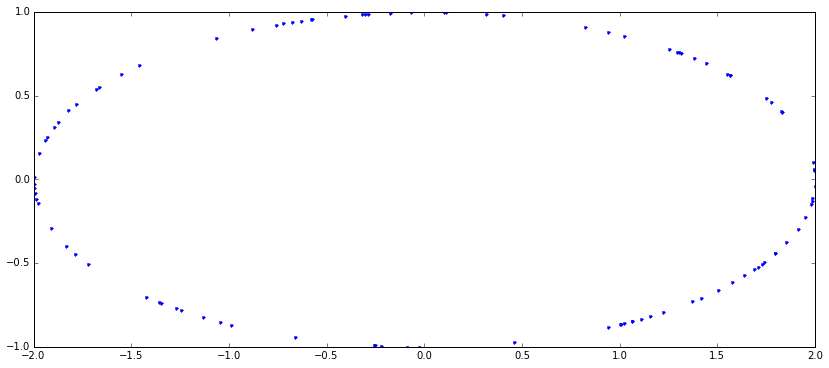

In [29]:
d = circle([2.0,1.0],100)
pl.plot(d[0,],d[1,],".")
pl.show()

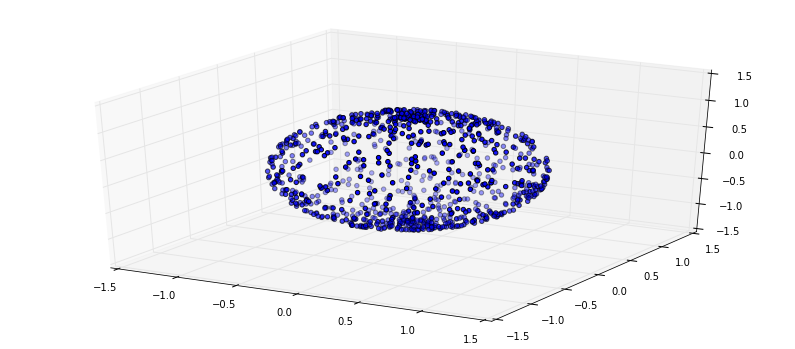

In [30]:
data = sphere([1.0,1.0,1.0],1000)
scatter3D(data).show()

## 5.2 The Autoencoder

The 'tanh' function as non-linear output scaling transfer function:

$$
o(x) = \frac{e^{wx} - e^{-{wx}}}{e^{wx} + e^{-{wx}}}
$$

Backpropagation training consists of (see training_step_stochastic for the implementation)

1. calculating the encoding of an example $x$ based on the model with Weights $W$ and bias $b$ as 
$$
y = o_{W,b}(x)
$$
2. reconstructing the example $x$ based on the model with Weights $W^T$ and bias $b'$ as
$$
z = o_{W^{t},b'}(y)
$$
3. calculating the error between example $x$ and reconstruction of $x$ as
$$
\delta_o = (x-z)
$$
4. updating the model by going from the reconstructed output $z$ to the hidden layer representation $y$ to the input layer $x$  
   - Output Layer:
        $$
        b'= b'+ \eta * (1-z^2) * \delta_o
        $$
        $$
        W.T= W.T + \eta * ((1-z^2) \cdot \delta_o) * y^T
        $$
   - Hidden Layer with error $\delta_h = (W * \delta_o) * (1-z^2)$
   $$
    b = b + \eta * (1-y^2) * \delta_h
   $$
   $$
    W = W + \eta * ((1-y^2) \cdot \delta_h)*x^T
    $$

see [backprop description](http://www.willamette.edu/~gorr/classes/cs449/backprop.html) for details. Note the difference between $\cdot$ as Pointwise prodcut and $*$  as matrix multiplication.


In [21]:
(5+3-1)/3

2

In [60]:
class Autoencoder(object):

    def __init__(self, in_size, hidden_size):
        self.w = np.random.random((hidden_size, in_size))
        self.b = np.random.random(hidden_size)
        self.b_rec = np.random.random(in_size)
        
    def out(self, x,w,b):
        # function that calculates the output of the network
        wx = np.sum(x * w,1) +b
        e_x = np.exp(wx)
        e_mx = np.exp(-1.0*wx)
        return (e_x-e_mx)/(e_x+e_mx)

    def encode(self, x): 
        return self.out(x,self.w,self.b)

    def decode(self, x): 
        return self.out(x,self.w.T,self.b_rec)

    def endecode(self, x):
        return self.decode(self.encode(x))
    
    def train_step_stochastic(self, x, eta=0.1):
        # todo: use elastic for learning
        # data is a 1d array with exactly 1 example
        # forward phase
        y = self.encode(x) # input to hidden layer activation
        z = self.decode(y) # hidden layer to output layer activation. Note that the weights are shared
        err = x - z # error at the ouput layer
        self.b_rec = self.b_rec + eta * (1 - z**2) * err # update the bias terms into the reconstruction layer
        dwt = eta * np.matrix(((1 - z**2) * err)).T * np.matrix(y)  # a matrix update. one row for every neuron in the hidden layer
        err_h = np.sum(self.w * err,1)  # error of the hidden layer.
        self.b = self.b + eta * (1 - y**2) * err_h # update the bias terms into the hidden layer.
        self.w = self.w + np.asarray(eta * np.matrix((1 - y**2) * err_h).T * np.matrix(x) + dwt.T) #
        return err
    
   
    def train(self, data, epochs=20, eta=0.1, callback=None):
        for j in xrange(epochs):
            sum_err = 0
            for i in xrange(data.shape[1]):
                err = self.train_step_stochastic(data[:,i], eta)
                sum_err += np.sum(err**2)/data.shape[1]
            if callback!=None:
                callback(j,sum_err)
        return self
    
    def decode_all(self, data):
        return np.array([self.decode(x) for x in data.T]).T
    
    def encode_all(self, data):
        return np.array([self.encode(x) for x in data.T]).T

    def plot(self,data, hidden_grid=False, color = None, return_hidden=False):
        if data.shape[0]==2:
            hidden = self.encode_all(data) #np.array([encode(x,w,b,b_rec) for x in data.T]).T
            if hidden_grid:
                hidden = np.linspace(-2,2,data.shape[1])
            reconstructed = self.decode_all(hidden) # np.array([decode(x,w,b,b_rec) for x in hidden.T]).T
            # plot the encoded points
            fig, ax = plt.subplots(1,2, figsize=(16,6))
            ax[0].plot(data[0],data[1],".")
            ax[0].set_title("data")
            pts = ax[1].scatter(reconstructed[0], reconstructed[1], marker="+", c=hidden, cmap=cm.bwr )
            ax[1].set_title("reconstruction")
            colorbar(pts)
            return fig
        elif data.shape[0]==3:
            hidden = self.encode_all(data) #np.array([encode(x,w,b,b_rec) for x in data.T]).T
            if hidden_grid:
                hidden = np.linspace(-2,2,data.shape[1])
            reconstructed = self.decode_all(hidden) # np.array([decode(x,w,b,b_rec) for x in hidden.T]).T
            num_fig = hidden.shape[0]/2
            fig_idx = (num_fig + 4)/3*100+30
            print "numfig", num_fig
            fig = plt.figure(figsize=(16,6))            
            for f in xrange(num_fig):
                ax = fig.add_subplot(fig_idx+f+1)
                x,y = 2*f, 2*f+1
                if y>=hidden.shape[0]:
                    y = 0
                if color is not None:
                    ax.scatter(hidden[x],hidden[y], c = color)
                else:
                    ax.scatter(hidden[x],hidden[y])
            ax.set_title("Embedding")
            ax = fig.add_subplot(fig_idx+f+2, projection='3d')
            if color is not None:
                ax.scatter(data[0], data[1], data[2], c = color)
            else:
                ax.scatter(data[0], data[1], data[2])
            ax.set_title("Original Data")
            ax = fig.add_subplot(fig_idx+f+3, projection='3d')
            if color is not None:
                ax.scatter(reconstructed[0], reconstructed[1], reconstructed[2], c = color)
            else:
                ax.scatter(reconstructed[0], reconstructed[1], reconstructed[2])                
            ax.set_title("Reconstructed data")
            if return_hidden:
                return fig, hidden
            else:
                return fig
        else: 
            return None
    
    
def cb_print(epoch,sse):
    if epoch%5==0:
        print(epoch, " sse=",sse)  

### 5.2.1 Training and Testing on a circle

**Circle:** The first experiment is a simple circle reduced to a 1D space. We can see that the hidden unit encodes a diameter. the direction depends on the initatlization and since there is no ability for reconstruction, the network can only retain 1 direction.

(0, ' sse=', 0.18882800711955572)
(5, ' sse=', 0.12570016940354356)
(10, ' sse=', 0.12514991222331689)
(15, ' sse=', 0.12474466095249316)
(20, ' sse=', 0.12450238528087962)
(25, ' sse=', 0.12436761553370641)
(30, ' sse=', 0.12429239027163577)
(35, ' sse=', 0.12424938218291562)


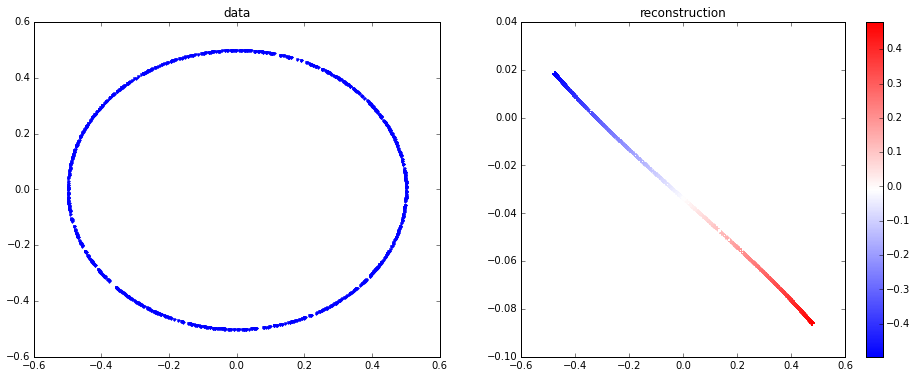

In [7]:
data = circle([0.5,0.5],1000)
ae = Autoencoder(data.shape[0],1)
ae.train(data, epochs=40, callback = cb_print, eta=0.01)
ae.plot(data).show()

**Eclipse:** next we try an eclipse. The cirlce is streched in  on direction. This direction has the greatest variance and the network should capture that direction. 

(0, ' sse=', 0.058593816981745428)
(5, ' sse=', 0.013299098797474053)
(10, ' sse=', 0.011463006495492721)
(15, ' sse=', 0.010472352198171057)


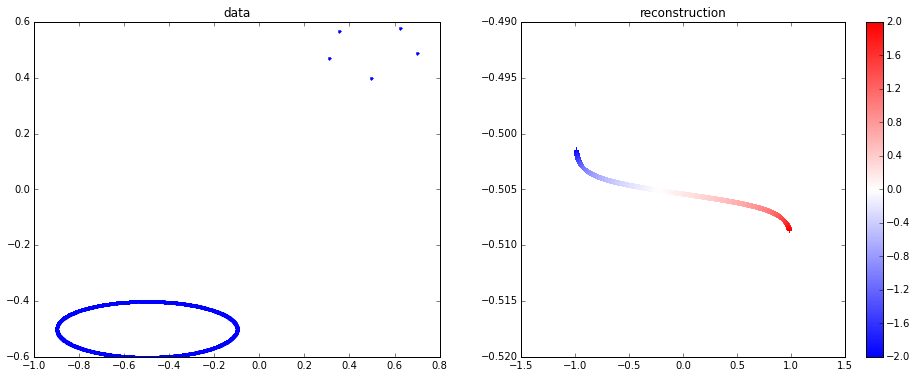

In [16]:
data = circle([0.2,0.1],5) + [[0.5],[0.5]]
data2 = circle([0.4,0.1],3000) - [[0.5],[0.5]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],1)
ae.train(data, epochs=20, callback = cb_print, eta=0.01)
ae.plot(data, hidden_grid=True).show()

(0, ' sse=', 0.11699069639392981)
(5, ' sse=', 0.0053911996250388308)


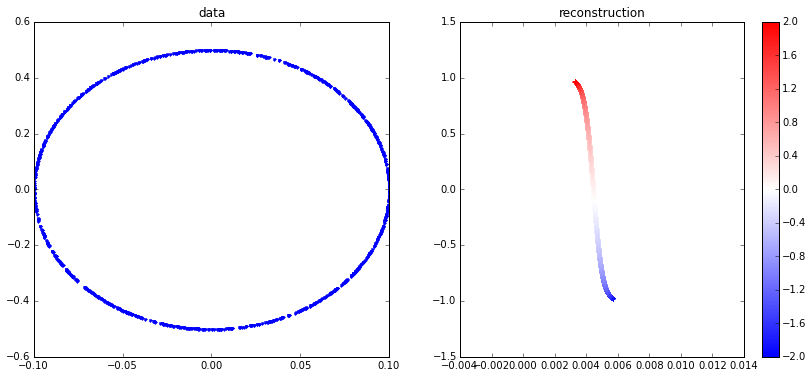

In [79]:
data = circle([0.1,0.5],1000)
ae = Autoencoder(data.shape[0],1)
ae.train(data, epochs=10, callback = cb_print, eta=0.01)
ae.plot(data,True).show() #show the full range of hidden units

### 5.2.2 Training a sphere

(2, 3)
(0, ' sse=', 0.31150121503601663)


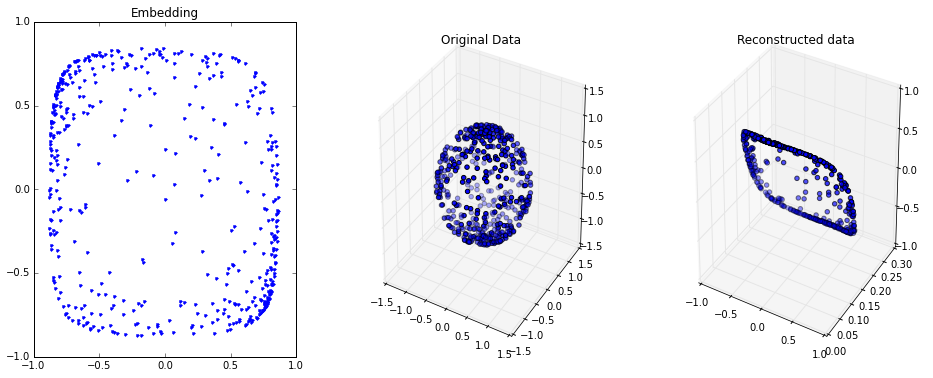

In [73]:
data = sphere([1.0,1.0,1.0],500)
ae = Autoencoder(data.shape[0],2)
print ae.w.shape
ae.train(data, epochs=2, callback = cb_print)
ae.plot(data).show()

### 5.2.3 Bi-Spherical Data

The following data set shows an interesting example. We have two eliptic spheres. Sphere 1 has a larger radius in the x-direction while sphere 2 has a larger radius in z-direction. The embedding tries to account for both directions, but since it only can embedd in a 2D space the reconstruction gets skewed in 3D. Note also that the reconstruction is not a real 3D, but the 2D images projected into 3D.

(0, ' sse=', 0.025213399362884786)
(5, ' sse=', 0.0033649060661427978)
(10, ' sse=', 0.0033627941422274678)
(15, ' sse=', 0.0033783897328931198)


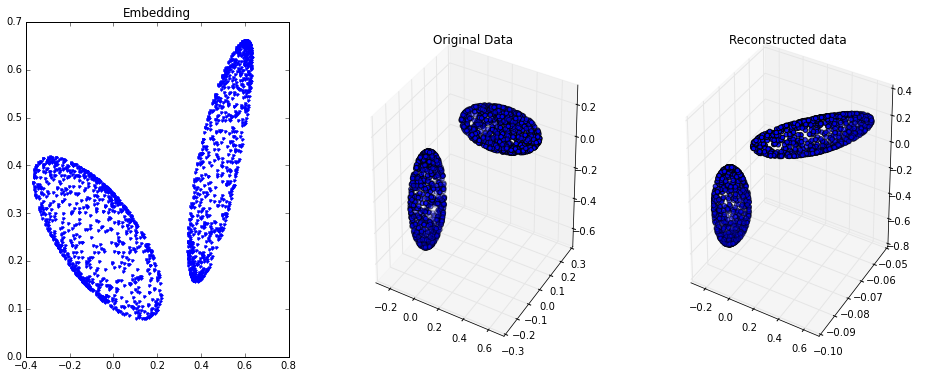

In [74]:
data = sphere([0.3,0.1,0.1], 1000) + [[0.3],[0.1],[0.1]]
data2 = sphere([0.1,0.1,0.3], 1000) - [[0.1],[0.1],[0.3]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train(data, epochs=20, callback = cb_print)
ae.plot(data).show()



Next we use slightly different orientation of the spheres.

(0, ' sse=', 0.023625541927054048)
(5, ' sse=', 0.0067746013409730604)
(10, ' sse=', 0.0068052734289114521)
(15, ' sse=', 0.0069548761566349182)


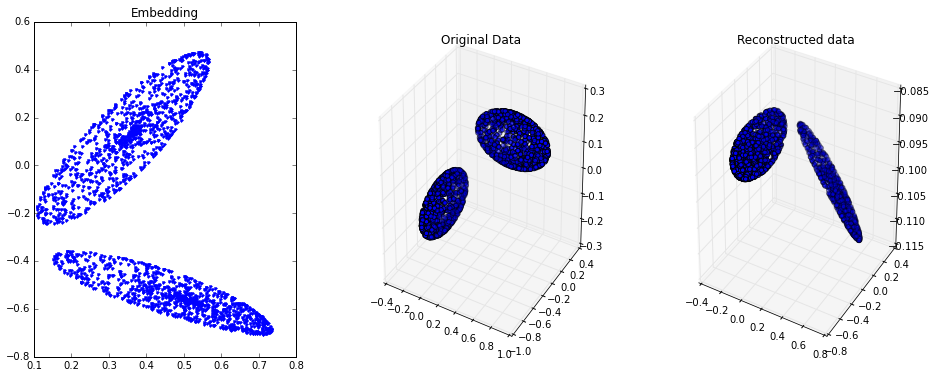

In [75]:
data = sphere([0.4,0.1,0.1], 1000) + [[0.4],[0.1],[0.1]]
data2 = sphere([0.1,0.4,0.1], 1000) - [[0.1],[0.4],[0.1]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train(data, epochs=20, callback = cb_print)
ae.plot(data).show()

## 5.3 Training and testing elastic learning

In elastic learning we train one neuron after another and expand the hidden layer size elastically. 
In the implementation here we do this in an inefficent way: we just set the error for a neuron to 0, thereby masking its error and prohibiting backprop updates. Similarly we mask the output of a neuron in the forward step by setting it to 0. Note that this only works with $\tanh$ since $\tanh(0)=0$. So the modified training process looks like ($\cdot$ marks the element-wise product (Hadamard product)):

1. calculating the encoding of an example $x$ based on the model with Weights $W$ and bias $b$ as 
<div style="color:green;">
$$
y = o_{W,b}(x)\cdot mask_{forward}
$$
</div><p>
2. reconstructing the example $x$ based on the model with Weights $W^T$ and bias $b'$ as
$$
z = o_{W^{t},b'}(y)
$$
3. calculating the error between example $x$ and reconstruction of $x$ as
$$
\delta_o = (x-z)
$$
4. updating the model by going from the reconstructed output $z$ to the hidden layer representation $y$ to the input layer $x$  
   - Output Layer:
        $$
        b'= b'+ \eta * (1-z^2) * \delta_o
        $$
        $$
        W.T= W.T + \eta * ((1-z^2) \cdot \delta_o) * y^T
        $$
   - Hidden Layer with error <span style="color:green;"> $\delta_h = (W * \delta_o) * (1-z^2)\cdot mask_{error}$ </span>
   $$
   b = b + \eta * (1-y^2) * \delta_h
   $$
   $$
   W = W + \eta * ((1-y^2) \cdot \delta_h)*x^T
   $$

5. For every hidden neuron $h$, train (i.e. do steps 1-4 over a number of examples) with the following mask setting
   - $ \forall_{i\leq h}\;mask_{forward}[i] = 1$
   - $mask_{error}[h] = 1$



**Implementation:** Note that the curretn implemenation is an inefficient way to do elastic learnign, since we calculate the full matrix in every training step. For imporving efficiency one would need to cache internal hidden layer states ($y$) and reconstruction ($z$) per example.

Software technical the following code does a monkey patch to the Autoencoder class.

**Some notes on the obtained results: ** 
1. When training the second unit, we also get an update on the first unit from the output layer due to the forward mask used. In the experiments that seemed to be repsonsible for the correct implementation of the autoencoder.
2. From 1. follows, that updating the weights only once per example (either for the hidden layer or the output layer) seems to be sufficient. How it affects convergence is an open question.

In [61]:
def train_step_stochastic_elastic(self, x, fwd_mask, err_mask, eta=0.1):
    # data is a 1d array with exactly 1 example
    # forward phase
    y = self.encode(x) # input to hidden layer activation
    if self.log_elastic > 2: print "forward mask", y, y*fwd_mask
    y = y * fwd_mask   # mask the network forward step
    z = self.decode(y) # hidden layer to output layer activation. Note that the weights are shared
    # the error mask only activates a certain output
    err = (x - z) # error at the ouput layer
    self.b_rec = self.b_rec + eta * (1 - z**2) * err # update the bias terms into the reconstruction layer
    dwt = eta * np.matrix(((1 - z**2) * err)).T * np.matrix(y)  # a matrix update. one row for every neuron in the hidden layer
    err_h = np.sum(self.w * err,1)  # error of the hidden layer.
    if self.log_elastic > 2: print "backprop mask", err_h, err_h*err_mask
    err_h = err_h*err_mask
    if self.log_elastic > 3: print "bias update:", self.b ,"+", eta * (1 - y**2) * err_h
    self.b = self.b + eta * (1 - y**2) * err_h # update the bias terms into the hidden layer.
    if self.log_elastic > 3: 
        print "matrix update:", self.w 
        print "+", eta * np.matrix((1 - y**2) * err_h).T * np.matrix(x)
        print "+", dwt.T                              
    self.w = self.w + np.asarray(eta * np.matrix((1 - y**2) * err_h).T * np.matrix(x) + dwt.T) #
    return err

def train_elastic(self, data, epochs=20, eta=0.1, callback=None):
    for h in xrange(self.w.shape[0]): #iterate over hidden nodes
        err_mask = np.zeros(self.w.shape[0]) # error mask determines which neuron is trained
        err_mask[h] = 1.0
        fwd_mask = np.zeros(self.w.shape[0])
        fwd_mask[:h+1] = 1.0
        if self.log_elastic>0 : print "training hidden neuron ", h, " with err mask", err_mask," and fwd mask",  fwd_mask
        for j in xrange(epochs):
            sum_err = 0
            for i in xrange(data.shape[1]):
                err = self.train_step_stochastic_elastic(data[:,i], fwd_mask, err_mask, eta)    
                sum_err += np.sum(err**2)/data.shape[1]
            if callback!=None:
                callback(j,sum_err)
    return self    

#Monkey patch the autoencoder
Autoencoder.train_step_stochastic_elastic = train_step_stochastic_elastic
Autoencoder.train_elastic = train_elastic
Autoencoder.log_elastic = 0

### 5.3.1 Functional test of elastic learning

training hidden neuron  0  with err mask [ 1.]  and fwd mask [ 1.]
(0, ' sse=', 0.080855449721865064)
IT WORKS!!!!!!!


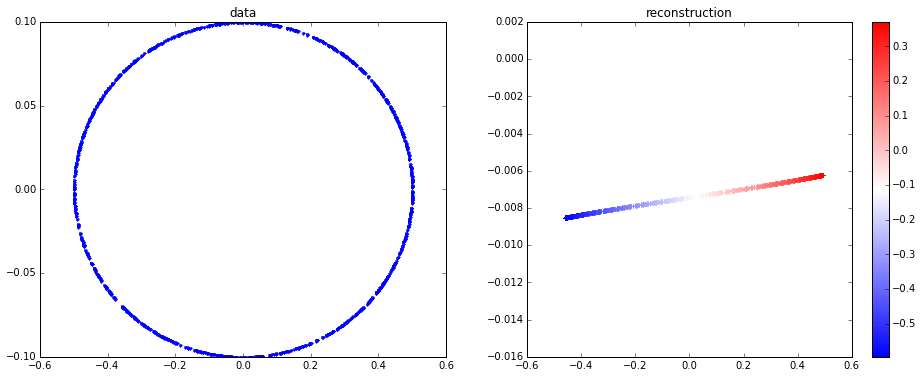

In [77]:
#nothing should change for a single hidden unit
Autoencoder.log_elastic = 1
data = circle([0.5,0.1],1000)
ae = Autoencoder(data.shape[0],1)
ae.train_elastic(data, epochs=5, callback = cb_print, eta=0.01)
ae.plot(data).show()
print "IT WORKS!!!!!!!"

### 5.3.2 Training an Elastic Autoencoder on a Sphere

The following code trains an elastic autoencoder on a sphere. It shows that the sphere can be well preserved. Their is no difference between the original trained AE and the elastically trained.

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
(0, ' sse=', 0.58106267213132257)
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
(0, ' sse=', 0.29982695578145119)


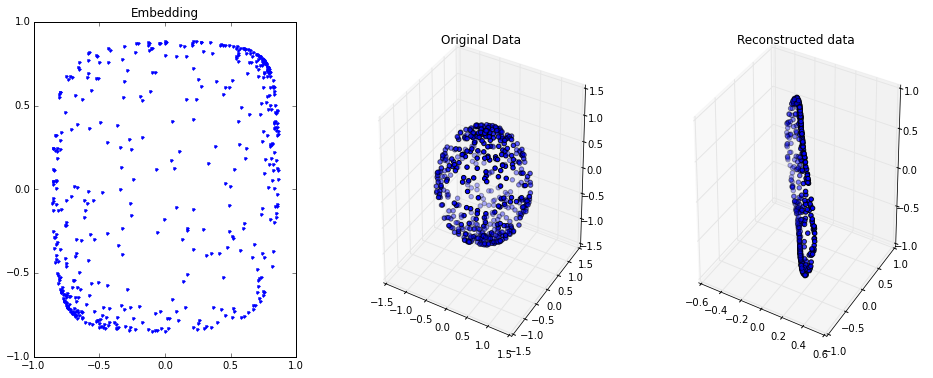

In [78]:
#uncoment the next two for seeing the updates happening
numpy.random.seed(12347)
#Autoencoder.log_elastic = 4
#data = sphere([1.0,1.0,1.0],5)
Autoencoder.log_elastic = 1
data = sphere([1.0,1.0,1.0],500)
ae = Autoencoder(data.shape[0],2)
ae.train_elastic(data, epochs=5, callback = cb_print)
ae.plot(data).show()

### 5.3.3 Training an Elastic Autoencoder on a Bi-Sphere

The following code trains an elastic autoencoder on a bi-sphere. It shows that both spheres can be well preserved. Their is no difference between the original trained AE and the elastically trained.

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
(0, ' sse=', 0.021865018109992095)
(5, ' sse=', 0.01741240591862786)
(10, ' sse=', 0.01749485883327731)
(15, ' sse=', 0.017502939903178763)
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
(0, ' sse=', 0.010488808384599294)
(5, ' sse=', 0.003353073475772675)
(10, ' sse=', 0.0032024941697774852)
(15, ' sse=', 0.0032043263962511005)


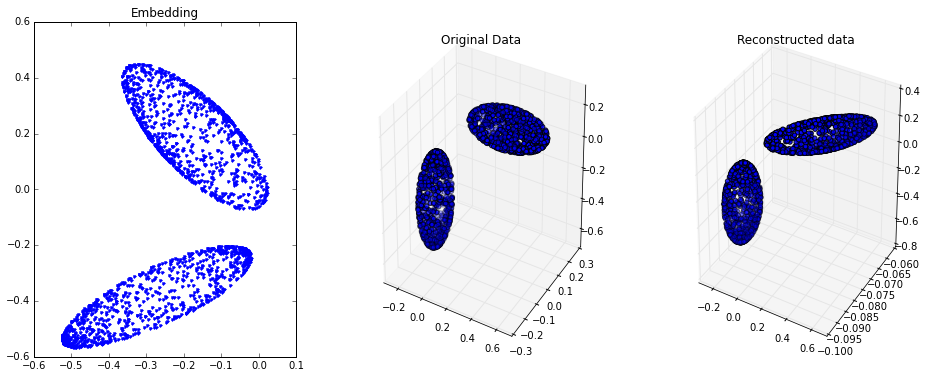

In [80]:
Autoencoder.log_elastic = 1
data = sphere([0.3,0.1,0.1], 1000) + [[0.3],[0.1],[0.1]]
data2 = sphere([0.1,0.1,0.3], 1000) - [[0.1],[0.1],[0.3]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train_elastic(data, epochs=20, callback = cb_print)
ae.plot(data).show()

## 5.4 Truly Elastic training - no weight updates to previous units 

In addition to the application of the masks in the previous elastic setting, we also apply the $mask_{error}$ to the  update of the output layer. This suppresses updating any weight of previously learned weights. So we get the following error estimate in step 3 above:

Update Outputlayer<span style="color:green;"> 
$$
        W.T= W.T + \eta * ((1-z^2) \cdot \delta_o) * (y\cdot mask_{error})^T
        $$
</span>

In [62]:
def train_step_stochastic_elastic2(self, x, fwd_mask, err_mask, eta=0.1):
    # data is a 1d array with exactly 1 example
    # forward phase
    y = self.encode(x) # input to hidden layer activation
    if self.log_elastic > 2: print "forward mask", y, y*fwd_mask, y*err_mask
    y = y * fwd_mask   # mask the network forward step
    z = self.decode(y) # hidden layer to output layer activation. Note that the weights are shared
    # the error mask only activates a certain output
    err = (x - z) # error at the ouput layer
    self.b_rec = self.b_rec + eta * (1 - z**2) * err # update the bias terms into the reconstruction layer
    dwt = eta * np.matrix(((1 - z**2) * err)).T * np.matrix(y*err_mask)  # a matrix update. one row for every neuron in the hidden layer
    err_h = np.sum(self.w * err,1)  # error of the hidden layer.
    if self.log_elastic > 2: print "backprop mask", err_h, err_h*err_mask
    err_h = err_h*err_mask
    if self.log_elastic > 3: print "bias update:", self.b ,"+", eta * (1 - y**2) * err_h
    self.b = self.b + eta * (1 - y**2) * err_h # update the bias terms into the hidden layer.
    if self.log_elastic > 3: 
        print "matrix update:", self.w 
        print "+", eta * np.matrix((1 - y**2) * err_h).T * np.matrix(x)
        print "+", dwt.T
    self.w = self.w + np.asarray(eta * np.matrix((1 - y**2) * err_h).T * np.matrix(x) + dwt.T) #
    return err

def train_elastic2(self, data, epochs=20, eta=0.1, callback=None):
    for h in xrange(self.w.shape[0]): #iterate over hidden nodes
        err_mask = np.zeros(self.w.shape[0]) # error mask determines which neuron is trained
        err_mask[h] = 1.0
        fwd_mask = np.zeros(self.w.shape[0])
        fwd_mask[:h+1] = 1.0
        if self.log_elastic>0 : print "training hidden neuron ", h, " with err mask", err_mask," and fwd mask",  fwd_mask
        for j in xrange(epochs):
            sum_err = 0
            for i in xrange(data.shape[1]):
                err = self.train_step_stochastic_elastic2(data[:,i], fwd_mask, err_mask, eta)    
                sum_err += np.sum(err**2)/data.shape[1]
            if callback!=None:
                callback(j,sum_err)
    return self    

#Monkey patch the autoencoder
Autoencoder.train_step_stochastic_elastic2 = train_step_stochastic_elastic2
Autoencoder.train_elastic2 = train_elastic2
Autoencoder.log_elastic = 0

### 5.4.1 Embedding a sphere - looks like traditional AEs and Elastic1

The following code embeds a sphere again. The results are the same as in the case of the autoencoder and the elastic1 variant. 

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
(0, ' sse=', 0.58106267213132257)
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
(0, ' sse=', 0.30995999442292954)


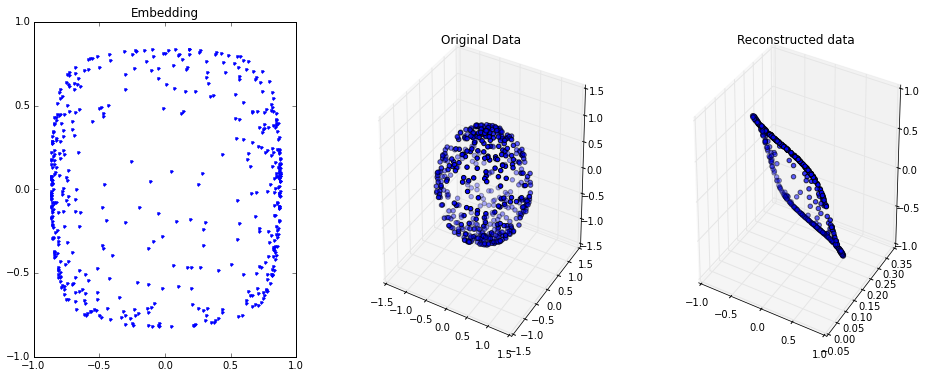

In [82]:
#uncoment the next two for seeing the updates happening
numpy.random.seed(12347)
#Autoencoder.log_elastic = 4
#data = sphere([1.0,1.0,1.0],5)
Autoencoder.log_elastic = 1
data = sphere([1.0,1.0,1.0],500)
ae = Autoencoder(data.shape[0],2)
ae.train_elastic2(data, epochs=5, callback = cb_print)
ae.plot(data).show()

### 5.4.2 Embedding a Bi-Sphere - Elastic 2 choose directions of greatest variance (!?!)

The following code embeds a bi-sphere. At the first glance they look similar to the traditional AE, however, on a closer look they are orthogonal to each other. This corresponds to a PCA based projection

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
(0, ' sse=', 0.02512105148028819)
(5, ' sse=', 0.017511604594007087)
(10, ' sse=', 0.017504699981484826)
(15, ' sse=', 0.017503952610357681)
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
(0, ' sse=', 0.0089082987380481159)
(5, ' sse=', 0.0038665336043683688)
(10, ' sse=', 0.0037993493784037064)
(15, ' sse=', 0.0037540392522657524)


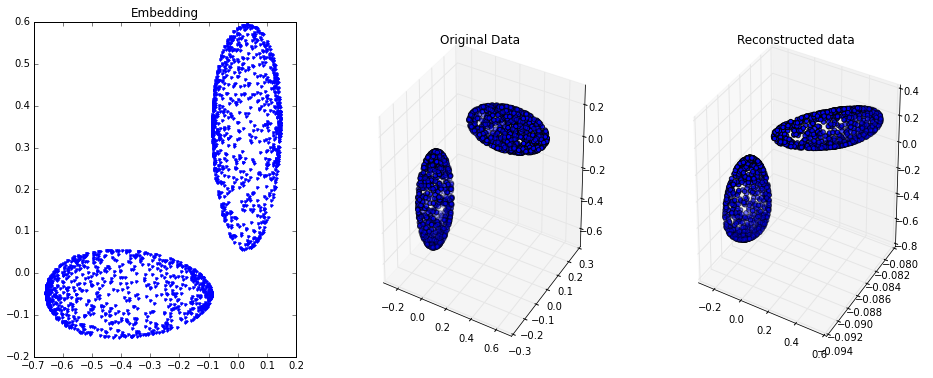

In [83]:
Autoencoder.log_elastic = 1
data = sphere([0.3,0.1,0.1], 1000) + [[0.3],[0.1],[0.1]]
data2 = sphere([0.1,0.1,0.3], 1000) - [[0.1],[0.1],[0.3]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train_elastic2(data, epochs=20, callback = cb_print)
ae.plot(data).show()

Compare with the elastic 1 version (which is similar to AE).

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
(0, ' sse=', 0.021865018109992095)
(5, ' sse=', 0.01741240591862786)
(10, ' sse=', 0.01749485883327731)
(15, ' sse=', 0.017502939903178763)
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
(0, ' sse=', 0.010488808384599294)
(5, ' sse=', 0.003353073475772675)
(10, ' sse=', 0.0032024941697774852)
(15, ' sse=', 0.0032043263962511005)


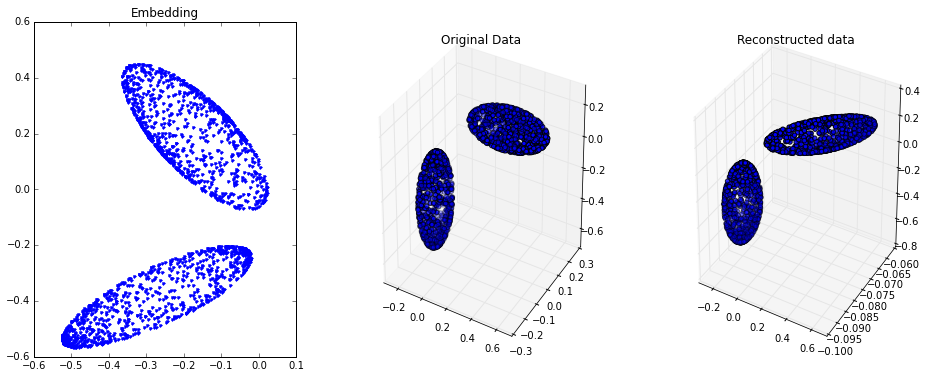

In [84]:
# now train elastic 1 version, which is the same as a regular autoencoder
Autoencoder.log_elastic = 1
data = sphere([0.3,0.1,0.1], 1000) + [[0.3],[0.1],[0.1]]
data2 = sphere([0.1,0.1,0.3], 1000) - [[0.1],[0.1],[0.3]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train_elastic(data, epochs=20, callback = cb_print)
ae.plot(data).show()

Now we change the directions of the spheres in two direction to study the effect with elastic1

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
(0, ' sse=', 0.047422660745803966)
(5, ' sse=', 0.028632872691778513)
(10, ' sse=', 0.028586853216083837)
(15, ' sse=', 0.028576590939764092)
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
(0, ' sse=', 0.015752899220600521)
(5, ' sse=', 0.014914466302216199)
(10, ' sse=', 0.014881020572452787)
(15, ' sse=', 0.014887349545430945)


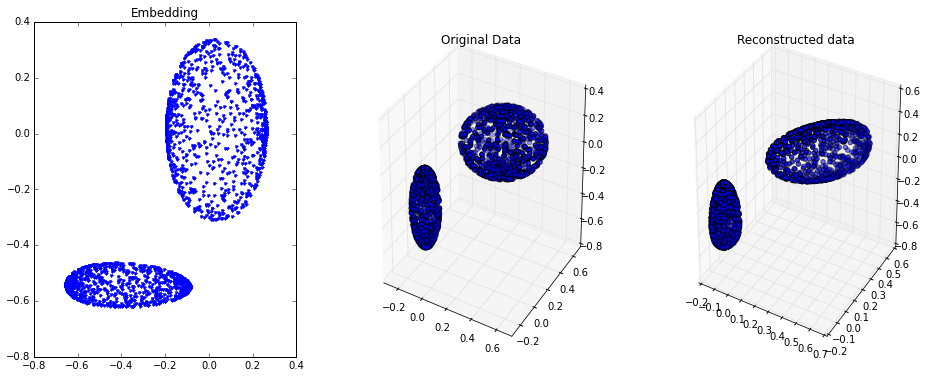

In [89]:
Autoencoder.log_elastic = 1
data = sphere([0.3,0.3,0.2], 1000) + [[0.3],[0.3],[0.1]]
data2 = sphere([0.1,0.1,0.3], 1000) - [[0.1],[0.1],[0.3]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train_elastic2(data, epochs=20, callback = cb_print)
ae.plot(data).show()

and now for elastic 2

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
(0, ' sse=', 0.037154735686547063)
(5, ' sse=', 0.028660672559343139)
(10, ' sse=', 0.028563736769684451)
(15, ' sse=', 0.028563236526399353)
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
(0, ' sse=', 0.017263899625435692)
(5, ' sse=', 0.014036404478710355)
(10, ' sse=', 0.014068680977928856)
(15, ' sse=', 0.014106013164103174)
Using matplotlib backend: MacOSX


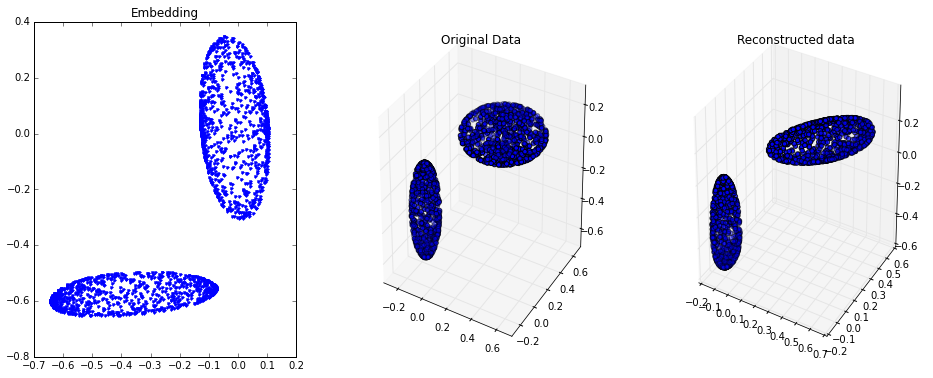

In [90]:
Autoencoder.log_elastic = 1
data = sphere([0.3,0.3,0.1], 1000) + [[0.3],[0.3],[0.1]]
data2 = sphere([0.1,0.1,0.3], 1000) - [[0.1],[0.1],[0.3]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train_elastic(data, epochs=20, callback = cb_print)
%matplotlib
ae.plot(data).show()

## Swiss Roll Data

The following example shows the Swiss Roll dataset and its embedding.
- AEs and Elastic learning behaves like MDS.
- Elastic learning 2 does not retain the structure.

Traditional Autoencoder


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


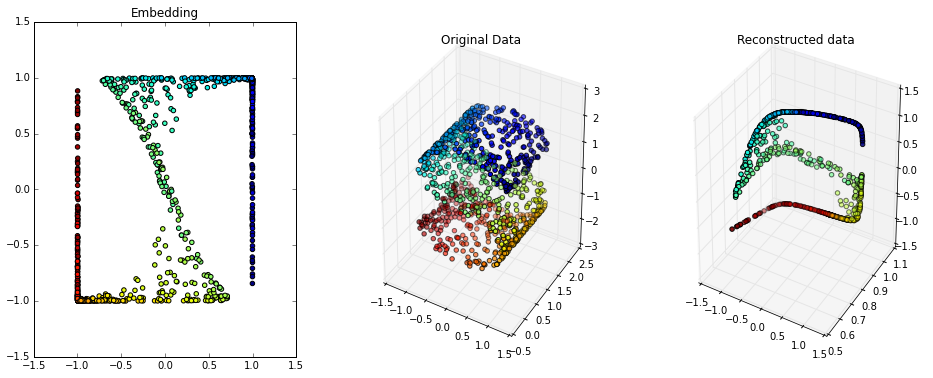

In [11]:
from sklearn import datasets
n_points=1000
sroll, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
sroll = sroll.T
Autoencoder.log_elastic = 1
ae = Autoencoder(sroll.shape[0],2)
ae.train(sroll, epochs=20)
%matplotlib inline
print "Traditional Autoencoder"
ae.plot(sroll, False, color).show()


Elastic Learning
training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]


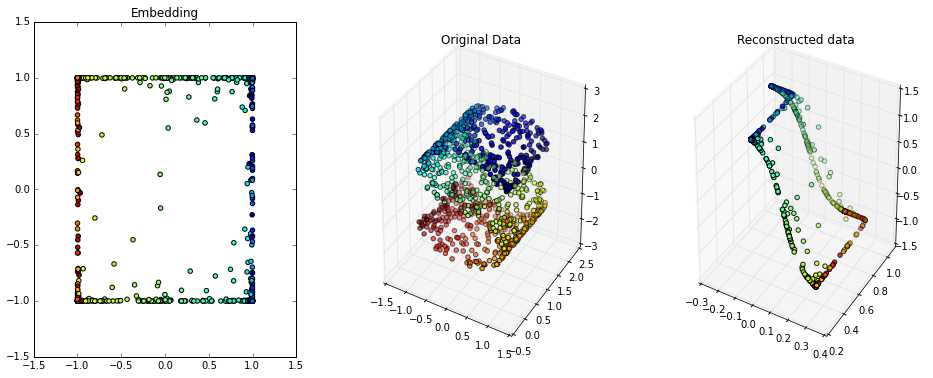

In [95]:
print "Elastic Learning"
ae = Autoencoder(sroll.shape[0],2)
ae.train_elastic2(sroll, epochs=20)
%matplotlib inline
ae.plot(sroll, False, color).show()

### Bi S-Rolls along the same and along different dimensions 

The S roll example can also be extended to two S roles, that either are oriented in the same dimension or not. This should affect the projection.

#### Bi S-Rolls along the same dimension

The embedding shows for both learning approaches that they can identify the correct sub-space. However, the data is easy, because they share similar directions.

Using matplotlib backend: MacOSX
Traditional Autoencoder


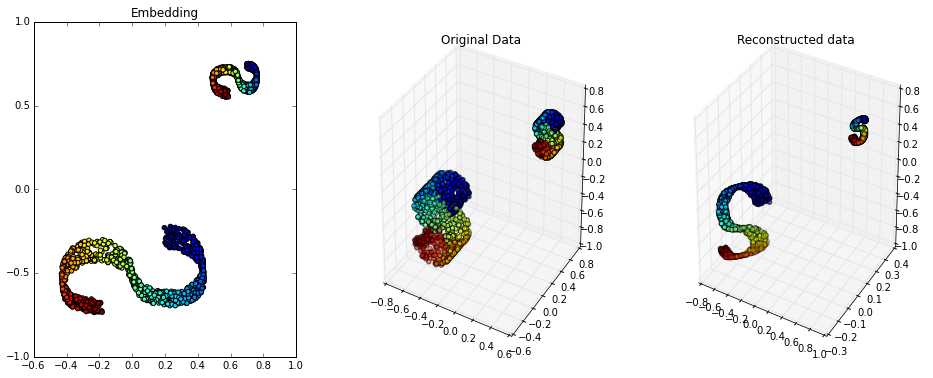

In [96]:
sroll, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
sroll2, color2 = datasets.samples_generator.make_s_curve(n_points, random_state=0)
sroll = sroll * 0.1 + [0.4, 0.4, 0.4]
sroll2 = sroll2 * 0.2 - [0.4, 0.4, 0.4]
sroll = np.append(sroll.T, sroll2.T, axis=1)
color = color - max(color)
color2 = color2 + min(color2)
color = np.append(color, color2)
Autoencoder.log_elastic = 1
ae = Autoencoder(sroll.shape[0],2)
ae.train(sroll, epochs=20)
%matplotlib
print "Traditional Autoencoder"
ae.plot(sroll, False, color).show()

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
Elastic Learning


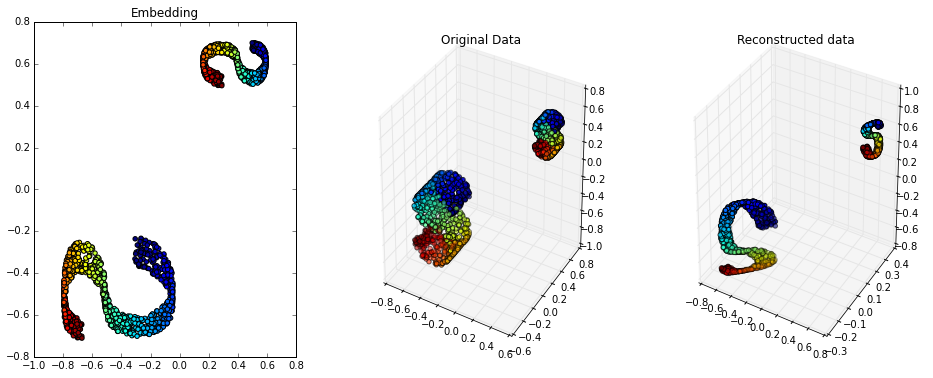

In [97]:
ae = Autoencoder(sroll.shape[0],2)
ae.train_elastic2(sroll, epochs=20)
%matplotlib inline
print "Elastic Learning"
ae.plot(sroll, False, color).show()

#### Bi S-Roll along the same dimension, but with different variance

By changing the variance in 1 direction and by changing the position to each other we can create good and bad embeddings.

Traditional Autoencoder


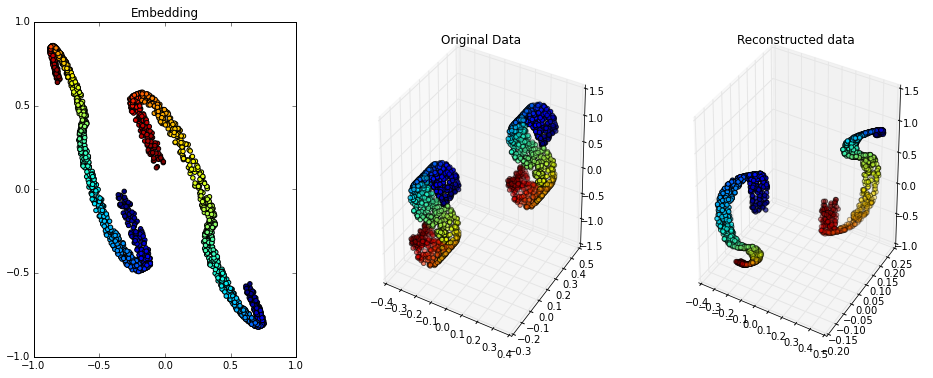

In [104]:
sroll, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
sroll2, color2 = datasets.samples_generator.make_s_curve(n_points, random_state=0)
# by changing the distance between the two S, one can make the reconstruction good and bad
sroll = sroll * [0.1, 0.1, 0.4] + [0.2, 0.2, 0.4] # [0.1, 0.1, 0.4] is bad, # [0.4, 0.4, 0.4] good
sroll2 = sroll2 * [0.1, 0.1, 0.4] - [0.2, 0.2, 0.4] # [0.1, 0.1, 0.4] is bad, # [0.4, 0.4, 0.4] good
sroll = np.append(sroll.T, sroll2.T, axis=1)
color = color - max(color)
color2 = color2 + min(color2)
color = np.append(color, color2)
Autoencoder.log_elastic = 1
ae = Autoencoder(sroll.shape[0],2)
ae.train(sroll, epochs=20)
%matplotlib inline
print "Traditional Autoencoder"
ae.plot(sroll, False, color).show()

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
Elastic Learning


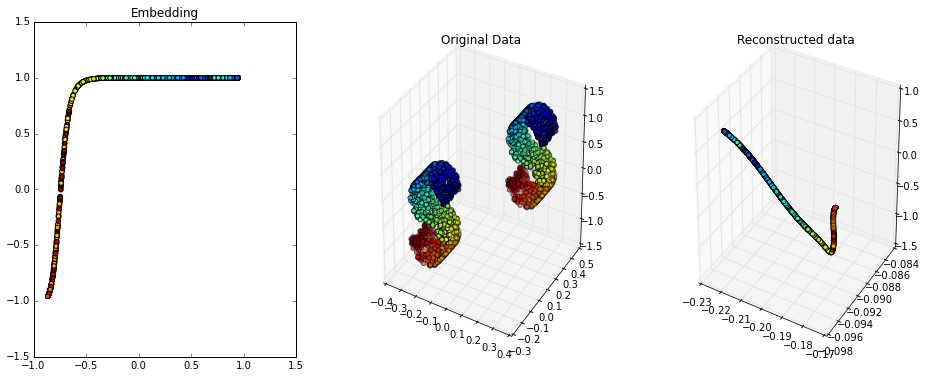

In [105]:
ae = Autoencoder(sroll.shape[0],2)
ae.train_elastic2(sroll, epochs=20)
%matplotlib inline
print "Elastic Learning"
ae.plot(sroll, False, color).show()

#### Bi S-Roll along differenet dimensions

We now change the orientation of the two s-rolls against each other. Both learning approach are mistaken by one or the other manifold. There is only 1 projection direction.

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
Traditional Autoencoder


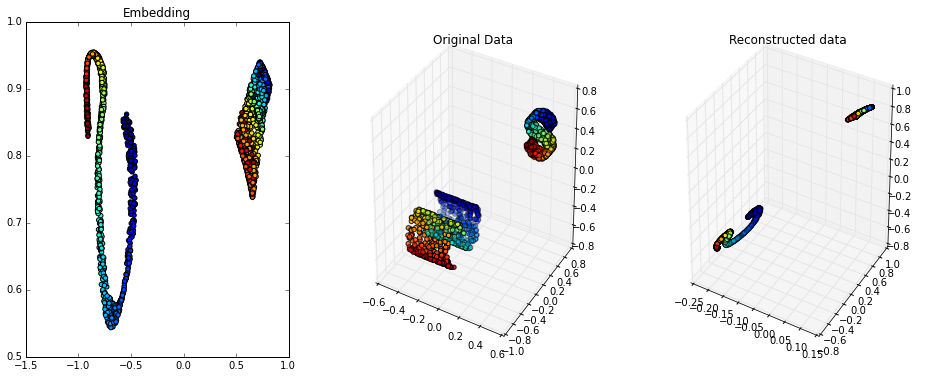

In [12]:
sroll, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
sroll2, color2 = datasets.samples_generator.make_s_curve(n_points, random_state=0)
sroll = sroll * 0.1 + [0.4, 0.4, 0.4]
sroll2 = sroll2 * 0.2 - [0.4, 0.4, 0.4]
sroll2 = np.array([sroll2.T[1,:], sroll2.T[2,:], sroll2.T[0,:]])
sroll = np.append(sroll.T, sroll2, axis=1)
color = color - max(color)
color2 = color2 + min(color2)
color = np.append(color, color2)
Autoencoder.log_elastic = 1
ae = Autoencoder(sroll.shape[0],2)
ae.train_elastic(sroll, epochs=20)
%matplotlib inline
print "Traditional Autoencoder"
ae.plot(sroll, False, color).show()

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
Traditional Autoencoder


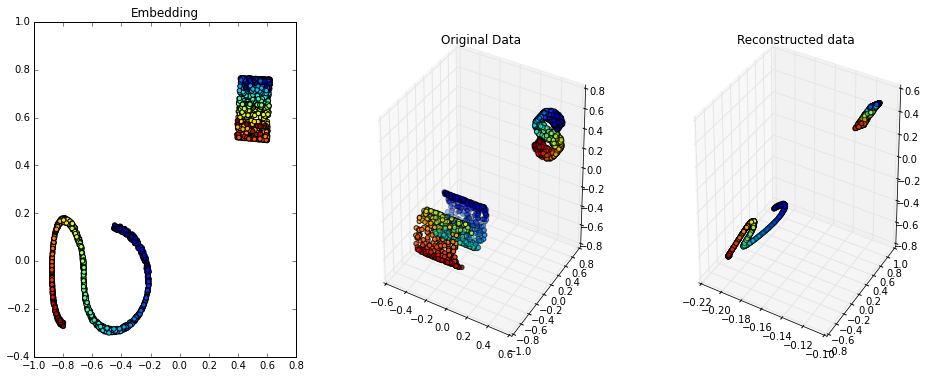

In [107]:
Autoencoder.log_elastic = 1
ae = Autoencoder(sroll.shape[0],2)
ae.train_elastic2(sroll, epochs=20)
%matplotlib inline
print "Traditional Autoencoder"
ae.plot(sroll, False, color).show()

and now we move the s-rolls close to each other.

In [9]:
sroll, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
sroll2, color2 = datasets.samples_generator.make_s_curve(n_points, random_state=0)
sroll = sroll * 0.1 + [0.1, 0.6, 0.1]
sroll2 = sroll2 * 0.2 - [0.2, 0.6, 0.2]
sroll2 = np.array([sroll2.T[1,:], sroll2.T[2,:], sroll2.T[0,:]])
sroll = np.append(sroll.T, sroll2, axis=1)
color = color - max(color)
color2 = color2 + min(color2)
color = np.append(color, color2)
Autoencoder.log_elastic = 1
ae = Autoencoder(sroll.shape[0],2)
ae.train(sroll, epochs=20)
%matplotlib inline
print "Traditional Autoencoder"
ae.plot(sroll, False, color).show()

NameError: name 'datasets' is not defined

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
Traditional Autoencoder
numfig 1


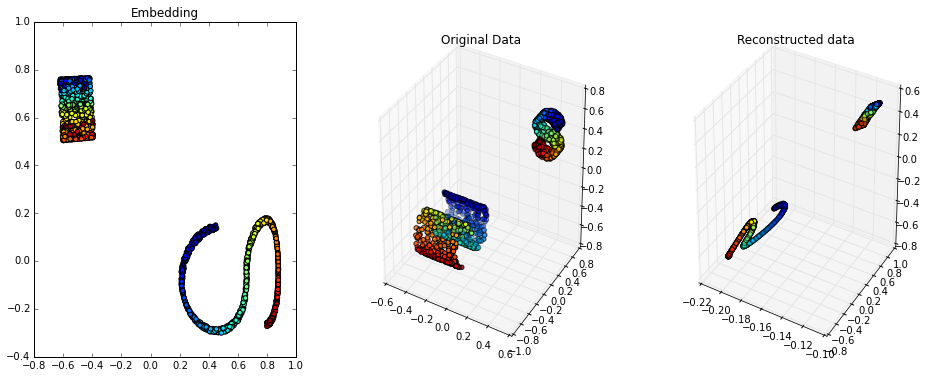

In [38]:
Autoencoder.log_elastic = 1
ae = Autoencoder(sroll.shape[0],2)
ae.train_elastic2(sroll, epochs=20)
%matplotlib inline
print "Traditional Autoencoder"
ae.plot(sroll, False, color).show()

## Generalized Elastic Training

Next we allow masks to train batches of neurons. Every batch is trained as autoencoder, while batches are joined via the training error. 

In [63]:
def train_elastic_batch(self, data, batch, epochs=20, eta=0.1, callback=None):
    prev = 0
    for h in batch: #iterate over hidden nodes
        err_mask = np.zeros(self.w.shape[0]) # error mask determines which neuron is trained
        err_mask[prev:h] = 1.0
        fwd_mask = np.zeros(self.w.shape[0])
        fwd_mask[:h] = 1.0
        prev = h
        if self.log_elastic > 0: 
            print "training hidden neuron ", h, " with err mask", err_mask," and fwd mask",  fwd_mask
        for j in xrange(epochs):
            sum_err = 0
            for i in xrange(data.shape[1]):
                err = self.train_step_stochastic_elastic2(data[:,i], fwd_mask, err_mask, eta)    
                sum_err += np.sum(err**2)/data.shape[1]
            if callback!=None:
                callback(j,sum_err)
    return self    
#Monkey patch the autoencoder
Autoencoder.train_elastic_batch = train_elastic_batch

In [162]:
#define a function that prints some errors/indicators for good topologies.
def print_errors(data):
    hidden = ae.encode_all(data)
    data_r = ae.decode_all(hidden)
    print "Reconstruction error per Dimension", np.sum((data-data_r)**2, axis=1)
    hidden_r = ae.encode_all(data_r)
    print "Deviation per hidden", np.sum((hidden-hidden_r)**2, axis=1)
    print "Linear Correlation"
    print np.corrcoef (hidden)

Observations from the experiments by changing the number of epochs and the hiddenlayer size:

- My hypothesis was, that batched learning more clearly identifies the two different structures. Sometinmes this was the case, sometimes it was not. maybe that is due to the different scale of the manifolds. 
- Traditional AE training always produces rather distorted manifolds. The inital embedding plot was a little bit misleading, since we do not know which neurons correlate with each other. therefore i added a scatterplot matrix.
- After making the scale of both S equal, it seems that the batched version finds the two S manifolds, while the non-batched version does not behave that way.
- It seems the non-batch version provides projections from very different angles comparable to moving the camera along the scene. However, it also contains redundant information. In one example i found that 1 neuron always retains 1 dimension of the S, while the other neurons add to it.
- Using perason correlation on the embedding with elastic training on single dimensions seems to allow the identification of unnecessary units. That could be a nice termination criterion. 

Few things from here on:

1. The network should somehow be able to limit its input space to a particular region. 
2. The mask should be learned, i.e. neurons should decide based on their mutual relationship when they activate their masks. For example , the neurons responsible for detecting the first S should "find themselves" by being activated in a similar manner. It is like Hebbian Learning. 

Point 1. seems to be most important to remove any distribution effects. However we can approximate this using more high-dimensional data, where manifolds live in separate sub-spaces (not in sub-regions of one space). Weights of sub-spaces a manifold is not contained in will be simply set to 0.

What is still not clear to me is wheter the power of AEs exactly comes from this kind of distribution along different projections. Not sure yet.

training hidden neuron  1  with err mask [ 1.  0.  0.  0.  0.  0.]  and fwd mask [ 1.  0.  0.  0.  0.  0.]
training hidden neuron  2  with err mask [ 0.  1.  0.  0.  0.  0.]  and fwd mask [ 1.  1.  0.  0.  0.  0.]
training hidden neuron  3  with err mask [ 0.  0.  1.  0.  0.  0.]  and fwd mask [ 1.  1.  1.  0.  0.  0.]
training hidden neuron  4  with err mask [ 0.  0.  0.  1.  0.  0.]  and fwd mask [ 1.  1.  1.  1.  0.  0.]
training hidden neuron  5  with err mask [ 0.  0.  0.  0.  1.  0.]  and fwd mask [ 1.  1.  1.  1.  1.  0.]
training hidden neuron  6  with err mask [ 0.  0.  0.  0.  0.  1.]  and fwd mask [ 1.  1.  1.  1.  1.  1.]
Two S-Roll Elastic, variance same
numfig 3
Reconstruction error per Dimension [ 0.59  2.72  0.39]
Deviation per hidden [ 1.823  0.304  0.496  0.057  0.058  0.007]
Linear Correlation
[[ 1.     0.614  0.663  0.914  0.953 -0.939]
 [ 0.614  1.     0.583  0.855  0.364 -0.339]
 [ 0.663  0.583  1.     0.727  0.617 -0.448]
 [ 0.914  0.855  0.727  1.     0.764 -0.7

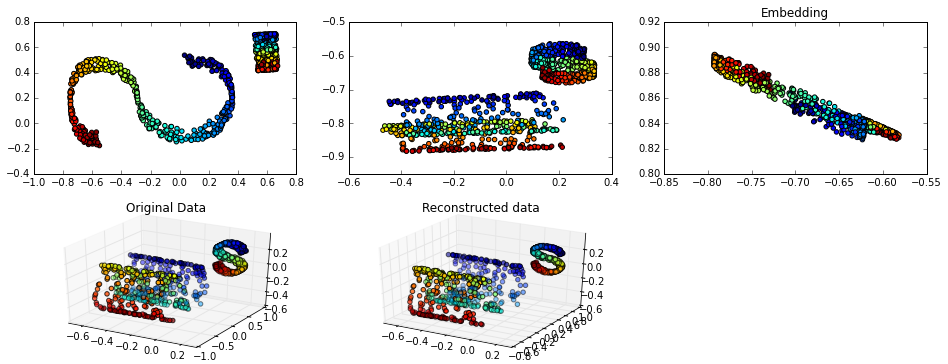

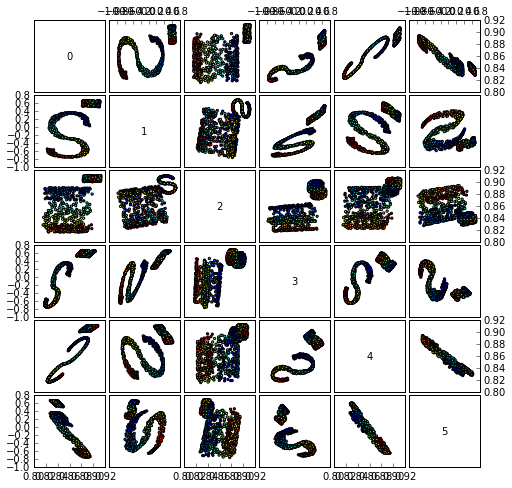

In [163]:
sroll, color = datasets.samples_generator.make_s_curve(500, random_state=0)
sroll2, color2 = datasets.samples_generator.make_s_curve(500, random_state=0)
sroll = sroll * 0.1 + [0.1, 0.6, 0.1]
sroll2 = sroll2 * 0.3 - [0.2, 0.6, 0.2]
sroll2 = np.array([sroll2.T[1,:], sroll2.T[2,:], sroll2.T[0,:]])
sroll = np.append(sroll.T, sroll2, axis=1)
color = color - max(color)
color2 = color2 + min(color2)
color = np.append(color, color2)
Autoencoder.log_elastic = 1
ae = Autoencoder(sroll.shape[0],6)
ae.train_elastic_batch(sroll, epochs=50, batch=range(1,7))
%matplotlib inline
print "Two S-Roll Elastic, variance same"
fig, hidden = ae.plot(sroll, False, color, return_hidden=True)
fig.show()
scatterplot_matrix(hidden, [str(u) for u in xrange(hidden.shape[0])], marker = ".", c=color).show()
np.set_printoptions(precision=3)
print_errors(sroll)
#compare the difference between encode/decode error per component

Traditional Autoencoder
numfig 3
Reconstruction error per Dimension [ 1.222  1.834  2.566]
Deviation per hidden [ 0.245  1.215  1.551  0.05   0.474  0.752]
Linear Correlation
[[ 1.     0.949 -0.593  0.667  0.927 -0.553]
 [ 0.949  1.    -0.8    0.666  0.952 -0.718]
 [-0.593 -0.8    1.    -0.539 -0.718  0.9  ]
 [ 0.667  0.666 -0.539  1.     0.441 -0.804]
 [ 0.927  0.952 -0.718  0.441  1.    -0.536]
 [-0.553 -0.718  0.9   -0.804 -0.536  1.   ]]


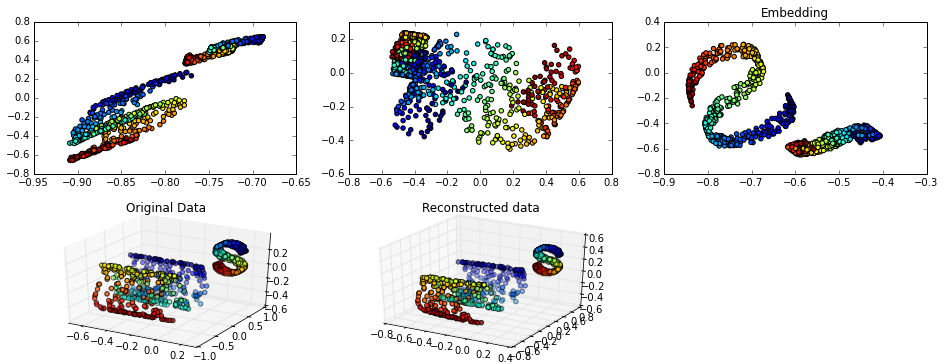

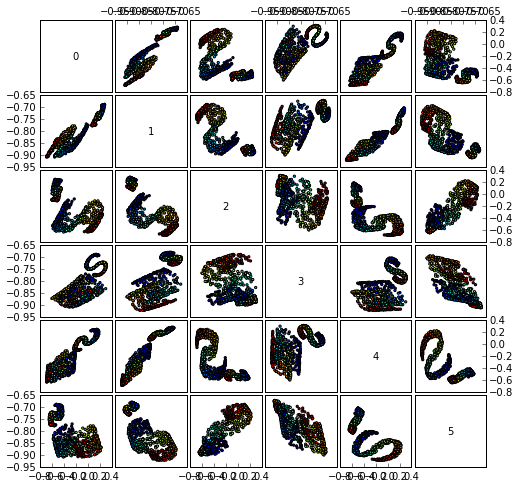

In [164]:
Autoencoder.log_elastic = 1
ae = Autoencoder(sroll.shape[0],6)
ae.train(sroll, epochs=20)
%matplotlib inline
print "Traditional Autoencoder"
fig, hidden = ae.plot(sroll, False, color, return_hidden=True)
fig.show()
scatterplot_matrix(hidden, [str(u) for u in xrange(hidden.shape[0])], marker = ".", c=color).show()
print_errors(sroll)

Batched Autoencoder
training hidden neuron  1  with err mask [ 1.  0.  0.  0.]  and fwd mask [ 1.  0.  0.  0.]
training hidden neuron  2  with err mask [ 0.  1.  0.  0.]  and fwd mask [ 1.  1.  0.  0.]
training hidden neuron  3  with err mask [ 0.  0.  1.  0.]  and fwd mask [ 1.  1.  1.  0.]
training hidden neuron  4  with err mask [ 0.  0.  0.  1.]  and fwd mask [ 1.  1.  1.  1.]
numfig 2
Reconstruction error per Dimension [ 1.702  2.864  0.752]
Deviation per hidden [ 1.692  0.679  1.652  0.063]
Linear Correlation
[[ 1.    -0.614  0.663  0.918]
 [-0.614  1.    -0.584 -0.848]
 [ 0.663 -0.584  1.     0.741]
 [ 0.918 -0.848  0.741  1.   ]]


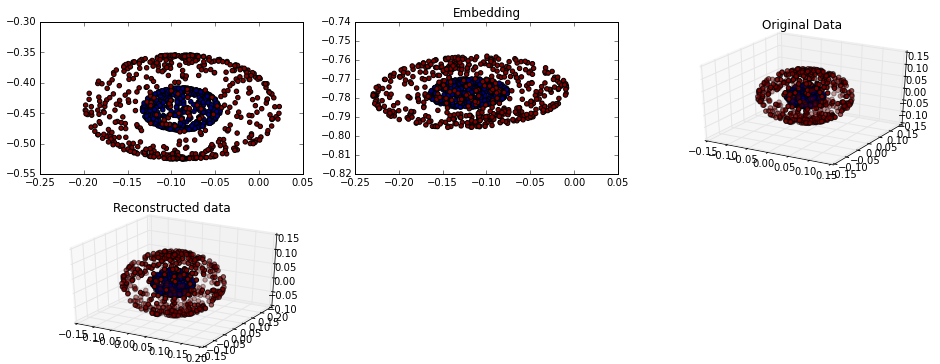

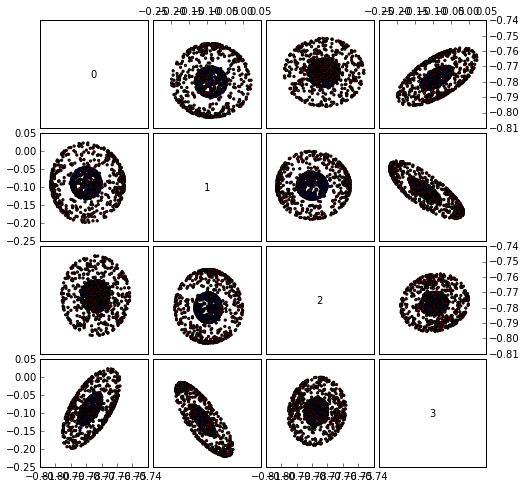

In [170]:
Autoencoder.log_elastic = 1
data = sphere([0.1,0.1,0.1], 500)*0.4 
data2 = sphere([0.1,0.1,0.1], 500)
c_sphere = np.array([np.zeros(500), np.ones(500)]).reshape(1000)
data = np.append(data, data2, axis=1)
ae = Autoencoder(sroll.shape[0],4)
ae.train(data, epochs=20)
%matplotlib inline
print "Batched Autoencoder"
ae.train_elastic_batch(sroll, epochs=50, batch=[1,2,3,4])
fig, hidden = ae.plot(data, False, c_sphere, return_hidden=True)
fig.show()
scatterplot_matrix(hidden, [str(u) for u in xrange(hidden.shape[0])], marker = ".", c=c_sphere).show()
print_errors(sroll)

Traditional Autoencoder
numfig 1
Reconstruction error per Dimension [ 55.488  11.276  10.559]
Deviation per hidden [ 4.195  4.354]
Linear Correlation
[[ 1.    -0.627]
 [-0.627  1.   ]]


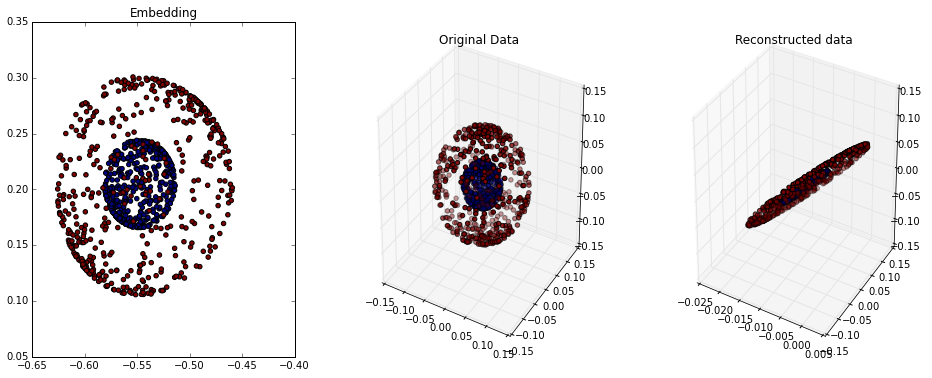

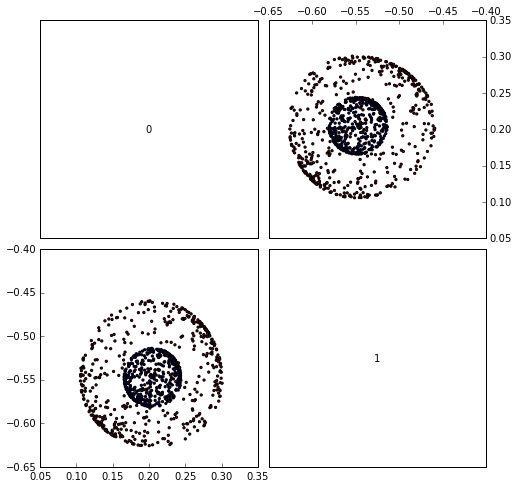

In [169]:
ae = Autoencoder(sroll.shape[0],2)
ae.train(data, epochs=20)
%matplotlib inline
print "Traditional Autoencoder"
fig, hidden = ae.plot(data, False, c_sphere, return_hidden=True)
fig.show()
scatterplot_matrix(hidden, [str(u) for u in xrange(hidden.shape[0])], marker = ".", c=c_sphere).show()
print_errors(sroll)

Given the two nested spheres, is the embedding good? It reflects the high-dimensional structure, but it does not disentangle the two spheres. 

#### S and Line - Does Correlation help in identifying oboslete neurons? 

training hidden neuron  1  with err mask [ 1.  0.  0.  0.  0.  0.]  and fwd mask [ 1.  0.  0.  0.  0.  0.]
training hidden neuron  2  with err mask [ 0.  1.  0.  0.  0.  0.]  and fwd mask [ 1.  1.  0.  0.  0.  0.]
training hidden neuron  3  with err mask [ 0.  0.  1.  0.  0.  0.]  and fwd mask [ 1.  1.  1.  0.  0.  0.]
training hidden neuron  4  with err mask [ 0.  0.  0.  1.  0.  0.]  and fwd mask [ 1.  1.  1.  1.  0.  0.]
training hidden neuron  5  with err mask [ 0.  0.  0.  0.  1.  0.]  and fwd mask [ 1.  1.  1.  1.  1.  0.]
training hidden neuron  6  with err mask [ 0.  0.  0.  0.  0.  1.]  and fwd mask [ 1.  1.  1.  1.  1.  1.]
Traditional Autoencoder
numfig 3
[[ 1.     0.669  0.727  0.719  0.979  0.938]
 [ 0.669  1.     0.512  0.772  0.701  0.78 ]
 [ 0.727  0.512  1.     0.924  0.829  0.869]
 [ 0.719  0.772  0.924  1.     0.829  0.91 ]
 [ 0.979  0.701  0.829  0.829  1.     0.984]
 [ 0.938  0.78   0.869  0.91   0.984  1.   ]]
[[ 0.108  0.019  0.011  0.007  0.007  0.006]
 [ 0.019 

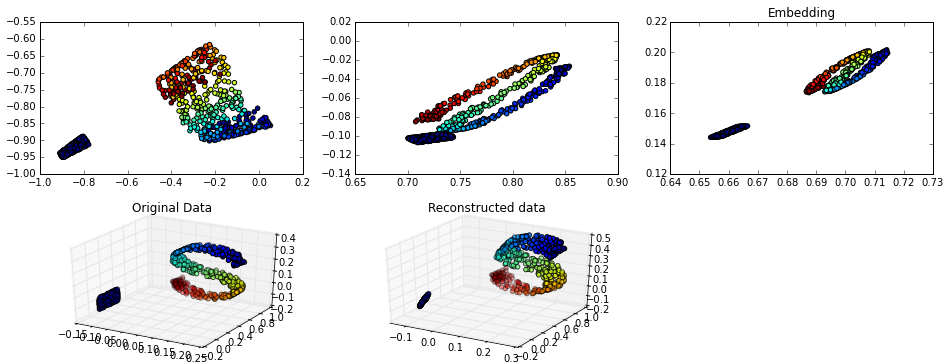

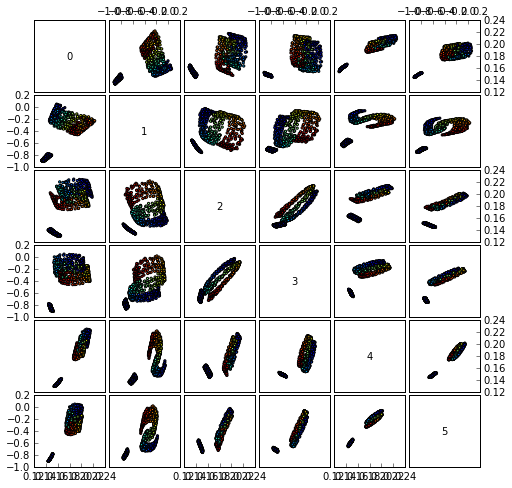

In [126]:
sroll, color = datasets.samples_generator.make_s_curve(500, random_state=0)
ldata = line(k=[0, 0.3,0.1], num=500)  - [[0.1], [0.1], [0.1]]
sroll = sroll * 0.1 + [0.1,0.6, 0.1]
sroll = np.append(sroll.T, ldata, axis=1)
color = color - min(color)
color = np.append(color, -0.1 * np.ones(ldata.shape[1]))
Autoencoder.log_elastic = 1
ae = Autoencoder(sroll.shape[0],4)
ae.train_elastic_batch(sroll, epochs=50, batch=range(1,5))
%matplotlib inline
print "Traditional Autoencoder"
fig, hidden = ae.plot(sroll, False, color, return_hidden=True)
fig.show()
scatterplot_matrix(hidden, [str(u) for u in xrange(hidden.shape[0])], marker = ".", c=color).show()
np.set_printoptions(precision=3)
print_errors(sroll)

Traditional Autoencoder
numfig 4
[[ 1.    -0.132  0.708  0.314 -0.025  0.316  0.398 -0.122]
 [-0.132  1.    -0.498  0.754  0.989  0.882 -0.849  0.967]
 [ 0.708 -0.498  1.     0.185 -0.479 -0.055  0.865 -0.332]
 [ 0.314  0.754  0.185  1.     0.743  0.937 -0.299  0.86 ]
 [-0.025  0.989 -0.479  0.743  1.     0.902 -0.852  0.933]
 [ 0.316  0.882 -0.055  0.937  0.902  1.    -0.545  0.901]
 [ 0.398 -0.849  0.865 -0.299 -0.852 -0.545  1.    -0.708]
 [-0.122  0.967 -0.332  0.86   0.933  0.901 -0.708  1.   ]]
[[ 0.006 -0.003  0.002  0.001 -0.     0.002  0.002 -0.001]
 [-0.003  0.087 -0.005  0.008  0.046  0.019 -0.013  0.022]
 [ 0.002 -0.005  0.001  0.    -0.002 -0.     0.001 -0.001]
 [ 0.001  0.008  0.     0.001  0.004  0.003 -0.001  0.002]
 [-0.     0.046 -0.002  0.004  0.025  0.011 -0.007  0.011]
 [ 0.002  0.019 -0.     0.003  0.011  0.006 -0.002  0.005]
 [ 0.002 -0.013  0.001 -0.001 -0.007 -0.002  0.003 -0.003]
 [-0.001  0.022 -0.001  0.002  0.011  0.005 -0.003  0.006]]


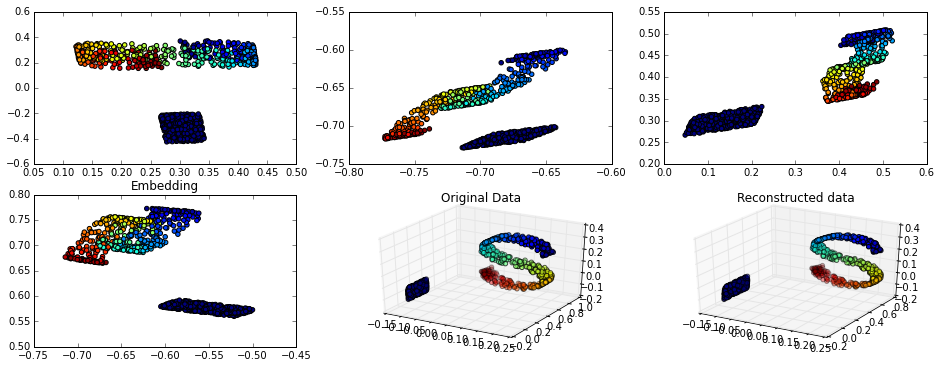

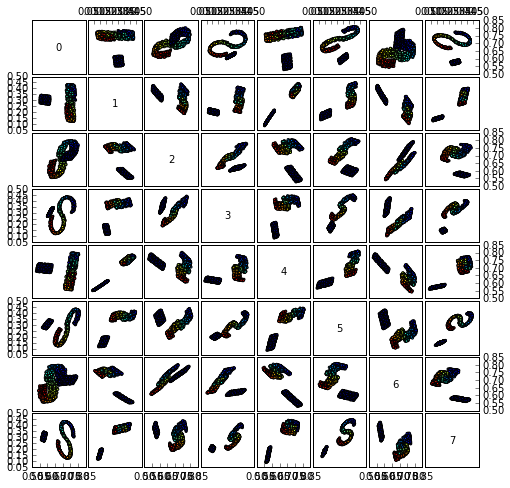

In [125]:
Autoencoder.log_elastic = 1
ae = Autoencoder(sroll.shape[0],8)
ae.train(sroll, epochs=20)
%matplotlib inline
print "Traditional Autoencoder"
fig, hidden = ae.plot(sroll, False, color, return_hidden=True)
fig.show()
scatterplot_matrix(hidden, [str(u) for u in xrange(hidden.shape[0])], marker = ".", c=color).show()
np.set_printoptions(precision=3)
print_errors(sroll)

####  Two lines - 2 neurons?

=== Distinguishing 2 lines using batch elastic ====
training hidden neuron  2  with err mask [ 1.  1.  0.  0.]  and fwd mask [ 1.  1.  0.  0.]
training hidden neuron  4  with err mask [ 0.  0.  1.  1.]  and fwd mask [ 1.  1.  1.  1.]
numfig 2
Reconstruction error per Dimension [ 0.4    0.292  0.078]
Deviation per hidden [ 0.073  0.244  0.187  0.057]
Linear Correlation
[[ 1.     0.974  0.952  0.988]
 [ 0.974  1.     0.946  0.994]
 [ 0.952  0.946  1.     0.933]
 [ 0.988  0.994  0.933  1.   ]]


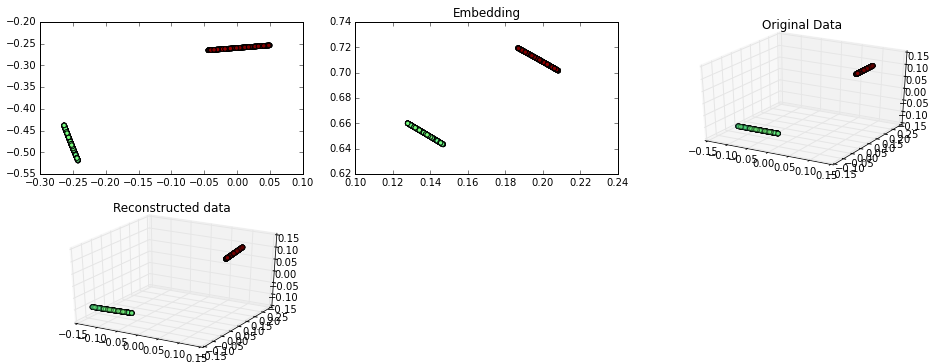

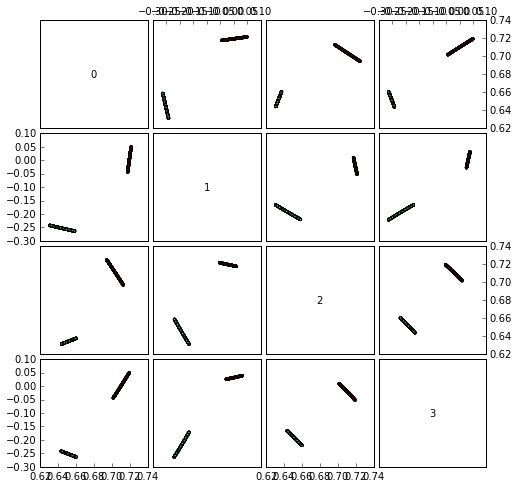

In [176]:
print "=== Distinguishing 2 lines using batch elastic ===="
ldata = np.append(line(k=[0.1, 0.0, 0.0], num=500)  - [[0.1], [0.1], [0.1]], \
                  line(k=[0, 0.1, 0.0], num=500)  + [[0.1], [0.1], [0.1]], axis=1)
color = np.array(range(0,1000))/1000.0
Autoencoder.log_elastic = 1
ae = Autoencoder(ldata.shape[0],4)
ae.train_elastic_batch(ldata, epochs=50, batch=[2,4])
%matplotlib inline
fig, hidden = ae.plot(ldata, False, color, return_hidden=True)
fig.show()
scatterplot_matrix(hidden, [str(u) for u in xrange(hidden.shape[0])], marker = ".", c=color).show()
np.set_printoptions(precision=3)
print_errors(ldata)

numfig 2
Reconstruction error per Dimension [ 0.06   0.001  0.2  ]
Deviation per hidden [ 0.012  0.011  0.008  0.14 ]
Linear Correlation
[[ 1.     0.973  0.971  0.989]
 [ 0.973  1.     0.996  0.973]
 [ 0.971  0.996  1.     0.958]
 [ 0.989  0.973  0.958  1.   ]]


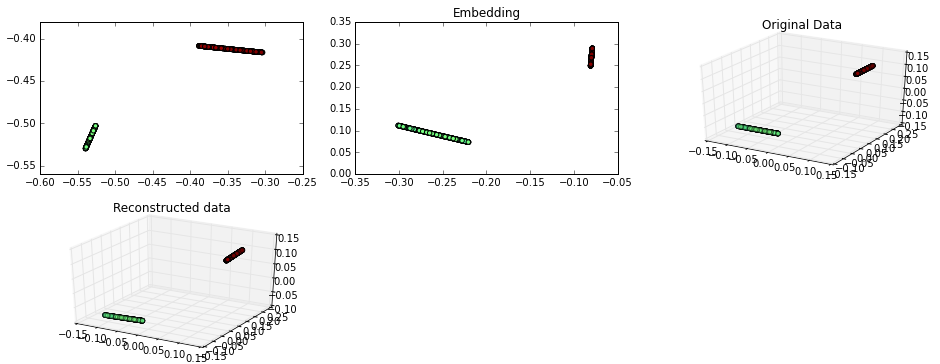

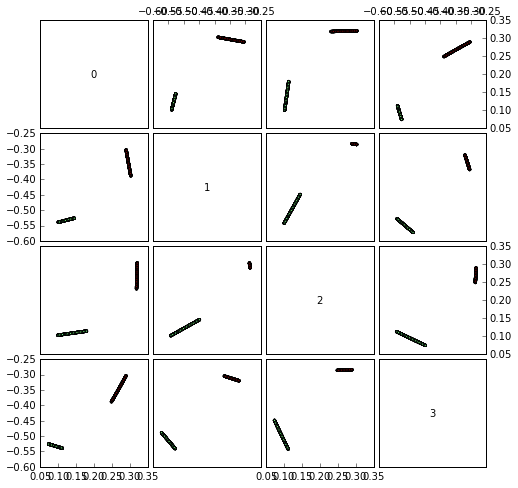

In [177]:
ae = Autoencoder(sroll.shape[0],4)
ae.train(ldata, epochs=50)
%matplotlib inline
fig, hidden = ae.plot(ldata, False, color, return_hidden=True)
fig.show()
scatterplot_matrix(hidden, [str(u) for u in xrange(hidden.shape[0])], marker = ".", c=color).show()
np.set_printoptions(precision=3)
print_errors(ldata)

#References

